In [1]:
import time
import ROOT
import numpy as np
import pandas as pd
import root_pandas as rpd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.colors import LogNorm
from root_pandas import read_root
from math import *
%run functions.ipynb

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed',)).History will not be written to the database.
Welcome to JupyROOT 6.14/06


In [2]:
def getJet(inputFiles):
    
    cols = []
    scalar = []
    
    scalar.append('njets')
    scalar.append('electron_truthPhi')
    scalar.append('electron_truthPt')
    scalar.append('electron_truthEta')
    
    cols.append('matched_truthNComponent')
    cols.append('pt')
    cols.append('eta')
    cols.append('phi')
    
    lists = scalar+cols
    dataframes = []
    for inputFilename in inputFiles:
        start = time.time()
        df = read_root(inputFilename, columns=lists, flatten=cols)
        dataframes.append(df)
        end = time.time()
        print '\n', 'Processed', inputFilename, 'in',  '%2.1f'%(end-start), 'seconds'
    return pd.concat([x for x in dataframes])

In [3]:
def getElectron(inputFiles):
    
    scalar = []
    
    scalar.append('njets')
    scalar.append('electron_truthPhi')
    scalar.append('electron_truthPt')
    scalar.append('electron_truthEta')
    
    dataframes = []
    for inputFilename in inputFiles:
        start = time.time()
        df = read_root(inputFilename, columns=scalar)
        dataframes.append(df)
        end = time.time()
        print '\n', 'Processed', inputFilename, 'in',  '%2.1f'%(end-start), 'seconds'
    return pd.concat([x for x in dataframes])

In [4]:
file1 = ["$HOME/EIC/output/allsi/710.root"]

In [5]:
aj = getJet(file1)
ae = getElectron(file1)


Processed $HOME/EIC/output/allsi/710.root in 55.5 seconds

Processed $HOME/EIC/output/allsi/710.root in 4.9 seconds


In [6]:
eq1 = "electron_truthP = electron_truthPt * cosh(electron_truthEta)"
eq2 = "p = pt * cosh(eta)"
eq3 = "Q2 = 40 * sqrt(electron_truthP**2 + 2.61119927e-7) * (1 - tanh(electron_truthEta))"
eq4 = "theta = 2 * arctan( exp(- electron_truthEta))"
eq5 = "theta_neg = 6.28318530718 - theta"

In [7]:
ae.eval(eq1, inplace = True)
ae.eval(eq3, inplace = True)
ae.eval(eq4, inplace = True)
aj.eval(eq1, inplace = True)
aj.eval(eq2, inplace = True)
aj.eval(eq3, inplace = True)
aj.eval(eq4, inplace = True)
aj.eval(eq5, inplace = True)

In [8]:
ae0 = applyCut(ae, 'Q2 > 16', 'Q2 > 16')

Q2 > 16 3875058  fraction kept: 99.8


In [9]:
aj.eval('dphi = phi - electron_truthPhi - 3.1415926535', inplace=True)
aj0 = fix_dphi(aj)
aj0 = applyCut(aj0, 'Q2 > 16', 'Q2 > 16')
aj0_dphi = applyCut(aj0, 'abs_dphi < 0.4', 'abs_dphi < 0.4 with fakes')
aj_array = partitionEta(aj0, np.arange(-0.1, 13.1, 1), 'njets')
aj_dphi_array = partitionEta(aj0_dphi, np.arange(-0.1, 13.1, 1), 'njets')

Fixed dphi delta phi range
Q2 > 16 9178300  fraction kept: 99.7
abs_dphi < 0.4 with fakes 3552193  fraction kept: 38.7
-0.1 < njets < 0.9 0  fraction kept: 0.0
0.9 < njets < 1.9 1054938  fraction kept: 11.5
1.9 < njets < 2.9 2580486  fraction kept: 28.1
2.9 < njets < 3.9 2637942  fraction kept: 28.7
3.9 < njets < 4.9 1708740  fraction kept: 18.6
4.9 < njets < 5.9 805245  fraction kept: 8.8
5.9 < njets < 6.9 289860  fraction kept: 3.2
6.9 < njets < 7.9 80213  fraction kept: 0.9
7.9 < njets < 8.9 17664  fraction kept: 0.2
8.9 < njets < 9.9 2826  fraction kept: 0.0
9.9 < njets < 10.9 330  fraction kept: 0.0
10.9 < njets < 11.9 44  fraction kept: 0.0
11.9 < njets < 12.9 12  fraction kept: 0.0
-0.1 < njets < 0.9 0  fraction kept: 0.0
0.9 < njets < 1.9 838854  fraction kept: 23.6
1.9 < njets < 2.9 1190434  fraction kept: 33.5
2.9 < njets < 3.9 852602  fraction kept: 24.0
3.9 < njets < 4.9 428845  fraction kept: 12.1
4.9 < njets < 5.9 169741  fraction kept: 4.8
5.9 < njets < 6.9 54314  fracti

In [10]:
radii = [0, 10, 20, 30, 40]
r_labels = ['$0$','$10$','$20$','$30$','$40$']
radii_s = [0, 5, 10, 15, 20]
r_labels_s = ['$0$','$5$','$10$','$15$','$20$']
angles = [90, 139.604937421, 164.585373193, 174.299529125, 177.90141703, 180, 182.09858297, 185.700470875, 195.414626807,
          220.395062579, 270, 319.604937421, 344.585373193, 354.299529125, 357.90141703, 360]
eta_labels=['0','-1','-2','-3','','','','-3','-2','-1','0','1','2','3','']
nr = 40
nr_s = 20
ntheta = 90

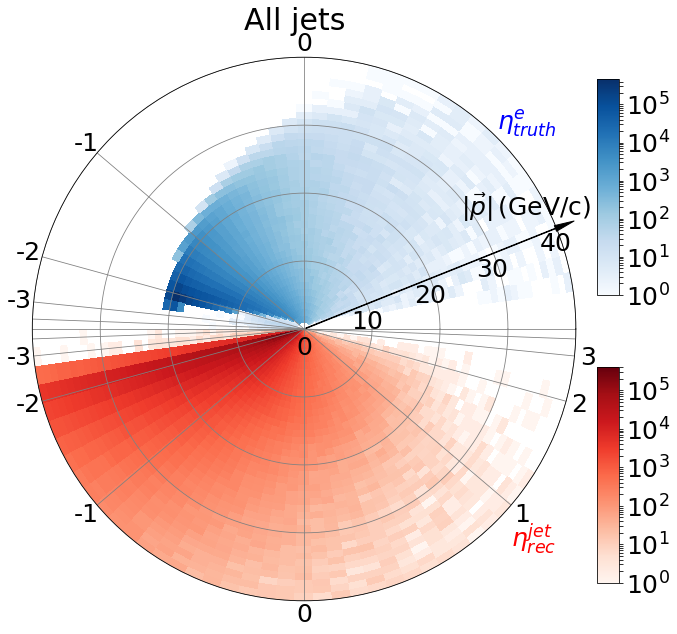

In [17]:
fig = plt.figure(figsize=(10,10))

ax1 = fig.add_subplot(111, polar=True)

r_edges = np.linspace(0, nr, nr + 1)
theta_edges = np.linspace(0, 2*np.pi, ntheta + 1)
H_e = plt.hist2d(ae0['electron_truthP'], ae0['theta'], [r_edges, theta_edges])[0]
H_q = plt.hist2d(aj0['p'], aj0['theta_neg'], [r_edges, theta_edges])[0]
ax1.cla()

Theta, R = np.meshgrid(theta_edges, r_edges)
im_e = ax1.pcolormesh(Theta, R, H_e, cmap='Blues', norm=LogNorm())
im_q = ax1.pcolormesh(Theta, R, H_q, cmap='Reds', norm=LogNorm())
ax1.set_rgrids(radii, labels=r_labels, fontsize=25)
ax1.set_thetagrids(angles, labels=eta_labels, fontsize=25)
ax1.grid(color='grey')
cbar_e = fig.colorbar(im_e, shrink=0.7, pad=0.01, cax=plt.axes([0.92, 0.55, 0.03, 0.3]))
cbar_e.ax.tick_params(labelsize=25)
cbar_q = fig.colorbar(im_q, shrink=0.7, pad=0.01, cax=plt.axes([0.92, 0.15, 0.03, 0.3]))
cbar_q.ax.tick_params(labelsize=25)
fig.text(0.78,0.78,'$\eta^{e}_{truth}$',fontsize=25, color='b')
fig.text(0.8,0.2,'$\eta^{jet}_{rec}$',fontsize=25, color='r')
ax1.annotate('', xy=(1,0.7), xycoords='axes fraction', xytext=(0.5,0.5), 
    arrowprops=dict(arrowstyle="Simple,tail_width=0.05,head_width=0.6,head_length=2", color='k'))
fig.text(0.73,0.66, r'$|\vec{p}| \, \mathrm{(GeV/c)}$',fontsize=25, color='k')
fig.suptitle('All jets',fontsize=30, y=0.95)
fig.savefig('images/polar1.pdf', bbox_inches='tight')

Text(0.5,1,'Jets are from 1-jet events')

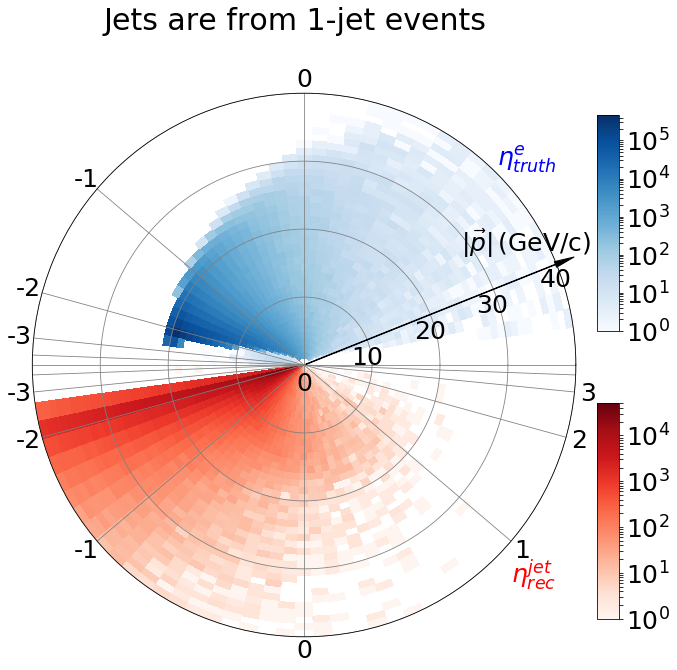

In [13]:
fig = plt.figure(figsize=(10,10))

ax1 = fig.add_subplot(111, polar=True)

r_edges = np.linspace(0, nr, nr + 1)
theta_edges = np.linspace(0, 2*np.pi, ntheta + 1)
H_e = plt.hist2d(ae0['electron_truthP'], ae0['theta'], [r_edges, theta_edges])[0]
H_q = plt.hist2d(aj_array[1]['p'], aj_array[1]['theta_neg'], [r_edges, theta_edges])[0]
ax1.cla()

Theta, R = np.meshgrid(theta_edges, r_edges)
im_e = ax1.pcolormesh(Theta, R, H_e, cmap='Blues', norm=LogNorm())
im_q = ax1.pcolormesh(Theta, R, H_q, cmap='Reds', norm=LogNorm())
ax1.set_rgrids(radii, labels=r_labels, fontsize=25)
ax1.set_thetagrids(angles, labels=eta_labels, fontsize=25)
ax1.grid(color='grey')
cbar_e = fig.colorbar(im_e, shrink=0.7, pad=0.01, cax=plt.axes([0.92, 0.55, 0.03, 0.3]))
cbar_e.ax.tick_params(labelsize=25)
cbar_q = fig.colorbar(im_q, shrink=0.7, pad=0.01, cax=plt.axes([0.92, 0.15, 0.03, 0.3]))
cbar_q.ax.tick_params(labelsize=25)
fig.text(0.78,0.78,'$\eta^{e}_{truth}$',fontsize=25, color='b')
fig.text(0.8,0.2,'$\eta^{jet}_{rec}$',fontsize=25, color='r')
ax1.annotate('', xy=(1,0.7), xycoords='axes fraction', xytext=(0.5,0.5), 
    arrowprops=dict(arrowstyle="Simple,tail_width=0.05,head_width=0.6,head_length=2", color='k'))
fig.text(0.73,0.66, r'$|\vec{p}| \, \mathrm{(GeV/c)}$',fontsize=25, color='k')
fig.suptitle('Jets are from 1-jet events',fontsize=30,y=0.96)
#fig.savefig('images/polar_jet_1.pdf', bbox_inches='tight')

Text(0.5,1,'Jets are from 2-jet events')

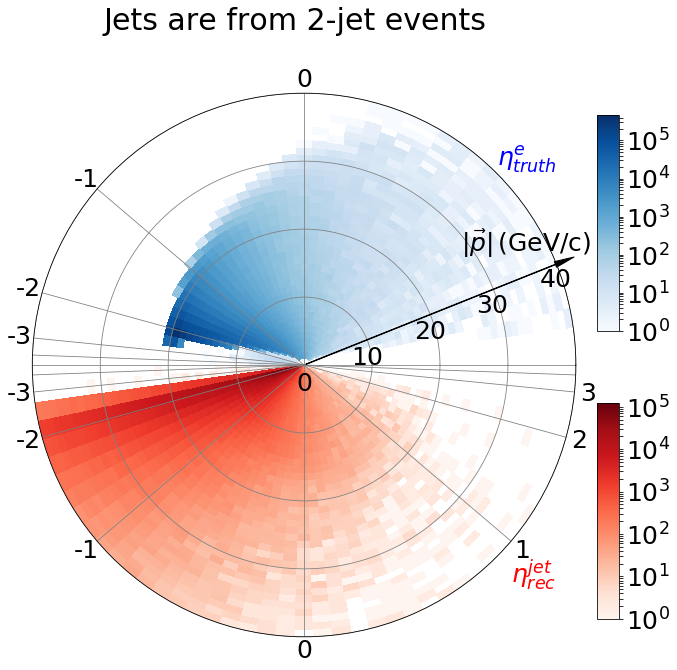

In [14]:
fig = plt.figure(figsize=(10,10))

ax1 = fig.add_subplot(111, polar=True)

r_edges = np.linspace(0, nr, nr + 1)
theta_edges = np.linspace(0, 2*np.pi, ntheta + 1)
H_e = plt.hist2d(ae0['electron_truthP'], ae0['theta'], [r_edges, theta_edges])[0]
H_q = plt.hist2d(aj_array[2]['p'], aj_array[2]['theta_neg'], [r_edges, theta_edges])[0]
ax1.cla()

Theta, R = np.meshgrid(theta_edges, r_edges)
im_e = ax1.pcolormesh(Theta, R, H_e, cmap='Blues', norm=LogNorm())
im_q = ax1.pcolormesh(Theta, R, H_q, cmap='Reds', norm=LogNorm())
ax1.set_rgrids(radii, labels=r_labels, fontsize=25)
ax1.set_thetagrids(angles, labels=eta_labels, fontsize=25)
ax1.grid(color='grey')
cbar_e = fig.colorbar(im_e, shrink=0.7, pad=0.01, cax=plt.axes([0.92, 0.55, 0.03, 0.3]))
cbar_e.ax.tick_params(labelsize=25)
cbar_q = fig.colorbar(im_q, shrink=0.7, pad=0.01, cax=plt.axes([0.92, 0.15, 0.03, 0.3]))
cbar_q.ax.tick_params(labelsize=25)
fig.text(0.78,0.78,'$\eta^{e}_{truth}$',fontsize=25, color='b')
fig.text(0.8,0.2,'$\eta^{jet}_{rec}$',fontsize=25, color='r')
ax1.annotate('', xy=(1,0.7), xycoords='axes fraction', xytext=(0.5,0.5), 
    arrowprops=dict(arrowstyle="Simple,tail_width=0.05,head_width=0.6,head_length=2", color='k'))
fig.text(0.73,0.66, r'$|\vec{p}| \, \mathrm{(GeV/c)}$',fontsize=25, color='k')
fig.suptitle('Jets are from 2-jet events',fontsize=30,y=1)
#fig.savefig('images/polar_jet_1.pdf', bbox_inches='tight')

Text(0.5,1,'Jets are from 3-jet events')

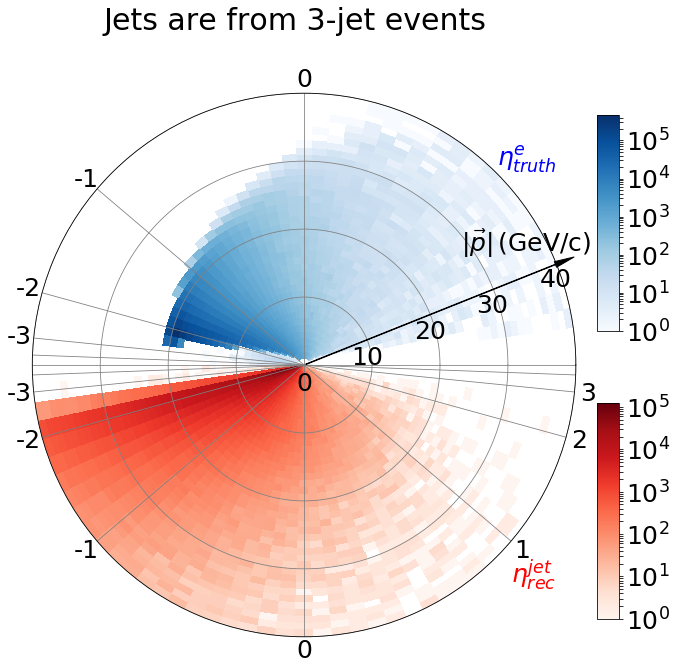

In [15]:
fig = plt.figure(figsize=(10,10))

ax1 = fig.add_subplot(111, polar=True)

r_edges = np.linspace(0, nr, nr + 1)
theta_edges = np.linspace(0, 2*np.pi, ntheta + 1)
H_e = plt.hist2d(ae0['electron_truthP'], ae0['theta'], [r_edges, theta_edges])[0]
H_q = plt.hist2d(aj_array[3]['p'], aj_array[3]['theta_neg'], [r_edges, theta_edges])[0]
ax1.cla()

Theta, R = np.meshgrid(theta_edges, r_edges)
im_e = ax1.pcolormesh(Theta, R, H_e, cmap='Blues', norm=LogNorm())
im_q = ax1.pcolormesh(Theta, R, H_q, cmap='Reds', norm=LogNorm())
ax1.set_rgrids(radii, labels=r_labels, fontsize=25)
ax1.set_thetagrids(angles, labels=eta_labels, fontsize=25)
ax1.grid(color='grey')
cbar_e = fig.colorbar(im_e, shrink=0.7, pad=0.01, cax=plt.axes([0.92, 0.55, 0.03, 0.3]))
cbar_e.ax.tick_params(labelsize=25)
cbar_q = fig.colorbar(im_q, shrink=0.7, pad=0.01, cax=plt.axes([0.92, 0.15, 0.03, 0.3]))
cbar_q.ax.tick_params(labelsize=25)
fig.text(0.78,0.78,'$\eta^{e}_{truth}$',fontsize=25, color='b')
fig.text(0.8,0.2,'$\eta^{jet}_{rec}$',fontsize=25, color='r')
ax1.annotate('', xy=(1,0.7), xycoords='axes fraction', xytext=(0.5,0.5), 
    arrowprops=dict(arrowstyle="Simple,tail_width=0.05,head_width=0.6,head_length=2", color='k'))
fig.text(0.73,0.66, r'$|\vec{p}| \, \mathrm{(GeV/c)}$',fontsize=25, color='k')
fig.suptitle('Jets are from 3-jet events',fontsize=30,y=1)
#fig.savefig('images/polar_jet_1.pdf', bbox_inches='tight')

Text(0.5,1,'Jets are from 4-jet events')

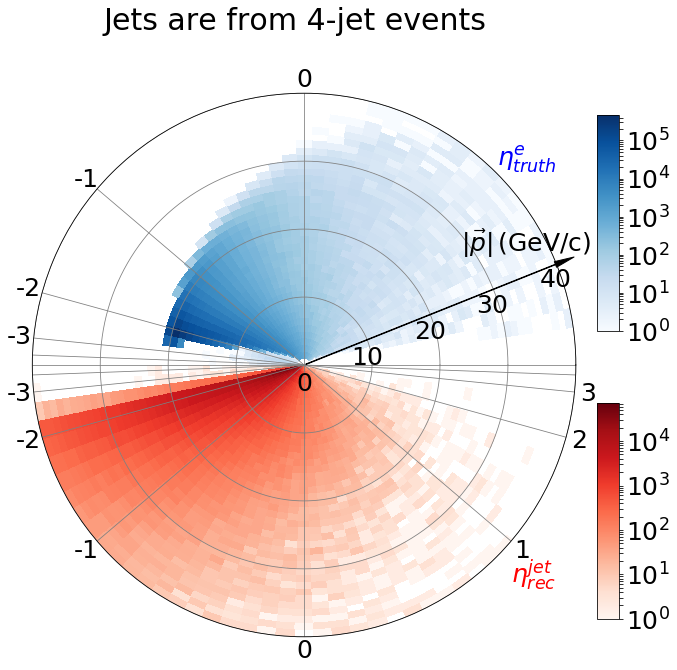

In [16]:
fig = plt.figure(figsize=(10,10))

ax1 = fig.add_subplot(111, polar=True)

r_edges = np.linspace(0, nr, nr + 1)
theta_edges = np.linspace(0, 2*np.pi, ntheta + 1)
H_e = plt.hist2d(ae0['electron_truthP'], ae0['theta'], [r_edges, theta_edges])[0]
H_q = plt.hist2d(aj_array[4]['p'], aj_array[4]['theta_neg'], [r_edges, theta_edges])[0]
ax1.cla()

Theta, R = np.meshgrid(theta_edges, r_edges)
im_e = ax1.pcolormesh(Theta, R, H_e, cmap='Blues', norm=LogNorm())
im_q = ax1.pcolormesh(Theta, R, H_q, cmap='Reds', norm=LogNorm())
ax1.set_rgrids(radii, labels=r_labels, fontsize=25)
ax1.set_thetagrids(angles, labels=eta_labels, fontsize=25)
ax1.grid(color='grey')
cbar_e = fig.colorbar(im_e, shrink=0.7, pad=0.01, cax=plt.axes([0.92, 0.55, 0.03, 0.3]))
cbar_e.ax.tick_params(labelsize=25)
cbar_q = fig.colorbar(im_q, shrink=0.7, pad=0.01, cax=plt.axes([0.92, 0.15, 0.03, 0.3]))
cbar_q.ax.tick_params(labelsize=25)
fig.text(0.78,0.78,'$\eta^{e}_{truth}$',fontsize=25, color='b')
fig.text(0.8,0.2,'$\eta^{jet}_{rec}$',fontsize=25, color='r')
ax1.annotate('', xy=(1,0.7), xycoords='axes fraction', xytext=(0.5,0.5), 
    arrowprops=dict(arrowstyle="Simple,tail_width=0.05,head_width=0.6,head_length=2", color='k'))
fig.text(0.73,0.66, r'$|\vec{p}| \, \mathrm{(GeV/c)}$',fontsize=25, color='k')
fig.suptitle('Jets are from 4-jet events',fontsize=30,y=1)
#fig.savefig('images/polar_jet_1.pdf', bbox_inches='tight')